# LT Toolbox Tutorial: 1. Trajectory Arrays

Welcome to the Lagrangian Trajectories Toolbox tutorial! 

The LT Toolbox is a Python library dedicated to the post-processing, visualisation and analysis of Lagrangian water parcel trajectories. The toolbox offers users two structures for working with Lagrangian trajectories: Trajectory Arrays (TrajArrays) and Trajectory Frames (TrajFrames). In this tutorial, we explore TrajArrays, which make use of [xarray](http://xarray.pydata.org/en/stable/#) multidimensional DataArrays to store attribute variables associated with trajectories (e.g. lat, lon, in-situ temperature etc.).

In this tutorial, we will show how to:

+ **Store** the output of an example simulation of the [TRACMASS](https://tracmass.readthedocs.io/en/latest/) Lagrangian trajectory code in a TrajArray object.

+ **Add** new variables, such as particle IDs and seeding levels, to your dataset.

+ **Filter** trajectories using any attribute variable contained in your dataset.

+ **Get** existing features, including trajectory start/end times, start/end locations and durations.

+ **Compute** metrics, such as distance travelled, particle displacements, velocities and Lagrangian probabilities from trajectories.

+ **Plot** trajectory data in the form of time series, temperature-salinity diagrams and more.

+ **Map** trajectories, properties and probability distributions onto the Earth's surface using [Cartopy](https://tracmass.readthedocs.io/en/latest/).

## Getting Started

Let us begin by importing the relevant packages we'll need to get started with the LT Toolbox. 

**Note**: Since lt_toolbox is still undergoing unit testing, the package is not yet available on PyPi, hence we use a local development version.

In [1]:
import sys
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Navigating to the local development version of lt_toolbox.
sys.path.append("/home/users/o_tooth/D.Phil./Software/lt_toolbox/")

from lt_toolbox.trajectory_array import TrajArray

### Storing Trajectory Data

To explore the functionality of the LT Toolbox, we will use output from the example NEMO ORCA1 (3D) simulation contained in the TRACMASS [documentation](https://tracmass.readthedocs.io/en/latest/Examples.html). 

The simulation uses monthly mean velocity fields (24 months continuously looped over to generate a 200 year simulation) and releases particles southward from \~68 N for the first 24 months (seeding levels). Particles are terminated on reaching the equator or on re-encountering the seeding plane (\~ 68 N). The maximum lifetime for trajectories in the simulation is 200 years.

TRACMASS outputs trajectories in .csv files, so we first used the export_tracmass_to_nc.py file to reformat the output data into a .nc file conforming to the standard NCEI trajectory [template](https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/trajectoryIncomplete.cdl).

Below we load the resulting .nc file as a DataSet with xarray, before creating a TrajArray, traj.

In [2]:
# Navigate to the directory where the ORCA1 output data is stored.
trajDir = "/home/users/o_tooth/D.Phil./Software/lt_toolbox/tutorials/data/"
trajFilename = "ORCA1-N406_TRACMASS_example.nc"

# Open output .nc file as a DataSet.
dataset = xr.open_dataset(trajDir + trajFilename)

# Create a TrajArray from the DataSet.
traj = TrajArray(dataset)
print(traj)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) timedelta64[ns] 0 days 30 days 60 days ... NaT NaT
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 ...
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...


/home/users/o_tooth/.conda/envs/jlab1/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/users/o_tooth/.conda/envs/jlab1/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


**What is a TrajArray?**

The TrajArray, traj, hosts the original xarray DataSet accessible as an attribute with traj.data. 

For improved functionality, attribute variables (data variables stored in our DataSet) are made accessible with traj.{variable} to access a given {variable}.

The true value of a trajectories object comes with the use of the built-in functions specifically designed for post-processing, visualisation and analysis of Lagrangain water parcel trajectories.

### Exploring our TrajArray

By accessing the .data attribute of our TrajArray above, we can see that attribute variables are formatted with dimensions **traj** (trajectory) and **obs** (observation - represents one time-level).

**Note**: Since trajectories are of differing lengths, missing **obs** values for a given **traj** are filled as NaNs or NaTs (time).

In [3]:
# To return details of our original DataSet.
print(traj)

# To access the temp attribute variable.
print(traj.temp)

# Using datetime64 format for time instead of timedelta64.
# Start date of simulation is 2000-01-01
traj = traj.use_datetime('2000-01-01')

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) timedelta64[ns] 0 days 30 days 60 days ... NaT NaT
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 ...
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
<xarray.DataArray 'temp' (traj: 800, obs: 120)>
[96000 values with dtype=float64]
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      temperature
    standard_name:  temperature
    units:          C


### Adding new attribute variables to our TrajArray.

To add a new attribute variable to a TrajArray, including appending it to the original DataSet, use the **.add_variable()** method. 

Two common attribute variables which a user may wish to add to their TrajArray, a unique trajectory id and the seeding level when a particles are released are included as seperate methods: **.add_id()** and **.add_seed()**.

In [4]:
# Suppose we would like to add the id and seeding level of all of our
# particles for future analysis. 

# We can combine methods on a single line to return both.
traj = traj.add_id().add_seed()

# Let's look at our new attribute variables.
print(traj.id)
print(traj.seed_level)

<xarray.DataArray 'id' (traj: 800)>
array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 1

In [5]:
# Consider now if we wanted to create a new attribute variable, temp_K,
# to store the in-situ temperature in Kelvin. 

# Using .values to access the numpy array storing the values of temp.
temp_k = traj.temp.values + 273.15

# Dictionary of attributes of our new variable.
attrs = {'long_name': 'in-situ temperature in Kelvin',
         'standard_name': 'temp_K',
         'units': 'Kelvin'
        }

# Add temp_k as a new attribute variable to our trajectories object.
traj = traj.add_variable(temp_k, attrs)

# Let's see if temp_K has been added!
print(traj.temp_K)

<xarray.DataArray 'temp_K' (traj: 800, obs: 120)>
array([[271.43, 271.43, 271.4 , ..., 277.95, 277.64,    nan],
       [271.43, 271.43, 271.42, ..., 277.08, 277.18,    nan],
       [271.43, 271.42, 271.42, ..., 276.12, 277.21,    nan],
       ...,
       [277.95, 278.14, 277.85, ...,    nan,    nan,    nan],
       [277.95, 278.14, 277.85, ...,    nan,    nan,    nan],
       [277.95, 278.12, 277.88, ...,    nan,    nan,    nan]])
Dimensions without coordinates: traj, obs
Attributes:
    long_name:      in-situ temperature in Kelvin
    standard_name:  temp_K
    units:          Kelvin


### Filtering trajectories using an attribute variable.

Filtering our trajectories to include only those complete trajectories where a specific criteria is met is integral to Lagrangian analysis. 

The LT Toolbox includes two fully vectorised methods **.filter_between()** and **filter_equal()** to allow users to filter on any attribute variable conatined in their TrajArray.

In [6]:
# Filtering all our trajectories to include only those released in 
# seeding level 1 and storing as a new trajectories object, traj_seed1.
traj_seed1 = traj.filter_equal('seed_level', 1, drop=False)

# Let's look at traj_seed1 - only 864 particles were
# released in seeding level 1.
print(traj_seed1)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT NaT
    lat         (traj, obs) float64 ...
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.72 -1.75 -1.77 ... nan nan nan nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 1 2 3 4 5 6 7 8 ... 793 794 795 796 797 798 799 800
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271.4 ... nan nan nan nan


In [7]:
# Filtering all our trajectories to include only those which travel 
# between 0 N - 25 N and storing as a new TrajArray, 
# traj_sublat.
traj_sublat = traj.filter_between('lat', 0, 25, drop=False)

# Let's look at traj_sublat - only 560 particles were
# found between 0-25 N at any time during their trajectories.
print(traj_sublat)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 37
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 10.0 10.0 10.0 10.0 ... 375.0 375.0 nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat         (traj, obs) float64 67.39 66.96 66.47 66.18 ... 18.27 18.18 nan
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.72 -1.73 -1.74 ... 21.31 22.05 nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 10 12 13 14 15 19 20 ... 160 161 162 163 288 375
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271.4 ... 294.5 295.2 nan


### Filtering trajectories by time - A Special Case

It should be noted that when filter methods are called with a time attribute variable, rather than return complete trajectories, only the observations (**obs**) meeting the specified criteria are returned. 

In [8]:
# Defining the min and maximum time levels to return obs for.
tmin = np.datetime64('2000-01-31')
tmax = np.datetime64('2000-03-31')

# Filtering between tmin and tmax, the values tmin and tmax are
# included, and storing as a new TrajArray, traj_subtime.
traj_subtime = traj.filter_between('time', tmin, tmax, drop=False)

# Let's look at traj_subtime - only 4 (116) obs are 
# included as expected.
print(traj_subtime)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 3
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 1.0 1.0 1.0 2.0 2.0 ... nan 800.0 800.0 nan
    time        (traj, obs) datetime64[ns] 2000-01-31 2000-03-01 ... NaT
    lat         (traj, obs) float64 66.53 66.16 66.12 66.6 ... 69.11 69.15 nan
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.75 -1.77 -1.72 ... 4.97 4.73 nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 1 2 3 4 5 6 7 8 ... 793 794 795 796 797 798 799 800
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271.4 ... 278.1 277.9 nan


In [9]:
# Defining the time level to return obs for.
tval = [np.datetime64('2000-01-31'), np.datetime64('2000-03-31')]

# Filtering tval and storing as a new TrajArray,
# traj_subtime.
traj_subtime = traj.filter_equal('time', tval, drop=False)

# Let's look at traj_subtime - only 1 (119) obs is 
# included as expected.
print(traj_subtime)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 2
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 1.0 1.0 2.0 2.0 3.0 ... 799.0 nan 800.0 nan
    time        (traj, obs) datetime64[ns] 2000-01-31 2000-03-31 ... NaT
    lat         (traj, obs) float64 66.53 66.12 66.6 66.16 ... nan 69.11 nan
    lon         (traj, obs) float64 ...
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.77 -1.72 -1.74 ... nan 4.97 nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 1 2 3 4 5 6 7 8 ... 793 794 795 796 797 798 799 800
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271.4 ... nan 278.1 nan


### Finding indices of trajectory points.

Often we would like to find the indices of the elements stored in a TrajArray meeting a specific condition. Here, we can use the __.find_between()__ and __.find_equal()__ methods. Both find methods return a tuple of arrays containing the indices for satisfactory trajectory points. 

In [10]:
# Finding trajectory points where a particle is found between
# 0 N - 25 N and storing indices in ind_between.
ind_between = traj.find_between('lat', 0, 25)

# Let's look at the indices returned in ind_between.
print(ind_between)
# To access only the rows in ind_between.
print(ind_between[0])
# To access only the cols in ind_between.
print(ind_between[1])

(array([  9,   9,   9,   9,   9,   9,  11,  11,  11,  11,  11,  11,  11,
        11,  11,  11,  11,  11,  11,  11,  12,  12,  12,  12,  12,  12,
        12,  12,  12,  13,  13,  14,  14,  14,  14,  18,  18,  18,  18,
        18,  18,  18,  18,  18,  18,  19,  19,  19,  19,  19,  19,  19,
        19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  19,  34,
        34,  34,  34,  34,  34,  34,  34,  51,  51,  51,  51,  51,  51,
        51,  51,  51,  51,  51,  51,  51,  51,  51,  51,  51,  51,  51,
        51,  51,  51,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
        52,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
        75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
        82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
        82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
        82,  82,  82,  82,  82,  82,  83,  83,  83,  83,  83,  83,  83,
        83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  

In [11]:
# Finding trajectory points where the in-situ temperature is -1.75C.
ind_equal = traj.find_equal('temp', -1.75)

# Let's look at the indices returned in ind_equal.
print(ind_equal)

(array([  0,  10,  26,  27,  28,  29,  30,  30,  31,  32,  35,  42,  44,
        67,  69,  69,  70,  74,  74,  75,  79, 106, 116, 119, 119, 120,
       121, 121, 122, 123, 124, 125, 126, 127, 149, 150, 151, 151, 154,
       157, 168, 173, 173, 174, 175, 178, 202, 203, 204, 205, 224, 238,
       238, 238, 239, 240, 241, 242, 243, 244, 252, 253, 256, 286, 382,
       383, 385, 420, 420, 420, 422, 423, 423, 424, 424, 425, 459, 464,
       464, 465, 466, 468]), array([ 2, 14,  2,  2,  2,  2,  2, 14,  2,  2,  2,  2,  2,  4,  2,  4,  4,
        2,  5,  2,  3, 85,  3,  2,  4,  2,  2,  4,  1,  1,  1,  1,  1,  1,
        2,  2,  2,  4,  3,  2, 62,  3,  4,  4,  4,  3,  5,  3,  3,  3,  2,
        1, 11, 12,  1,  1,  1,  1,  1,  1,  1,  1,  0,  1,  1,  1, 24, 23,
       39, 40,  4,  4, 14,  4, 14,  4, 14,  3,  4, 15,  4,  3]))


### Filtering trajectories which intersect a polygon.

In [12]:
# Defining square as a list of (Lat, Lon) tuples storing the coordinates
# of the polygon boundary.
square = [[[-60, 30], [-60, 35], [-30, 35], [-30, 30], [-60, 30]]]

# Filtering all our trajectories to include only those which, at some 
# point in their life time intersect a simple polygon, square.
traj_poly = traj.filter_polygon(polygon=square, method='pos', drop=False)

# Let's look at the resulting TrajArray.
print(traj_poly)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 12
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 12.0 12.0 12.0 12.0 ... 159.0 159.0 nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat         (traj, obs) float64 67.39 67.02 66.6 66.15 ... 24.54 24.31 nan
    lon         (traj, obs) float64 -63.27 -63.07 -62.77 ... -45.43 -45.74 nan
    z           (traj, obs) float64 ...
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.72 -1.73 -1.73 ... 22.17 22.17 nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 12 13 28 76 77 83 84 90 129 131 137 159
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271.4 ... 295.3 295.3 nan


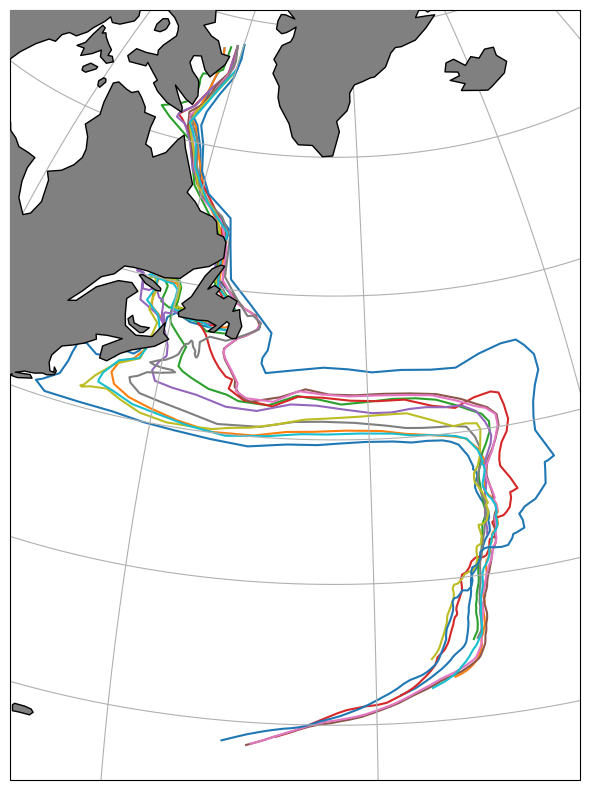

In [13]:
# Let's look at a map of the resulting trajectories. 
traj_poly.map_trajectories()

### Finding trajectory points that intersect a polygon.

In [14]:
# Finding trajectory points which intersect a simple polygon, square.
ind_poly = traj.find_polygon(square)

# Let's look at the resulting indices returned in ind_poly.
ind_poly

(array([ 11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,  11,
         11,  11,  11,  12,  12,  12,  12,  12,  12,  12,  12,  12,  12,
         27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,  27,
         27,  27,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,  75,
         75,  75,  76,  76,  76,  76,  76,  76,  76,  76,  76,  82,  82,
         82,  82,  82,  82,  82,  83,  83,  83,  83,  83,  83,  83,  89,
         89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,  89,
         89,  89, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 130,
        130, 130, 130, 130, 130, 130, 130, 130, 130, 136, 136, 136, 136,
        136, 136, 136, 136, 158, 158, 158, 158]),
 array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
 

### Getting existing features from a TrajArray.

The LT Toolbox includes a range of .get_ methods to extract important features from existing attribute variables in a TrajArray. 

In [15]:
# Get the times and locations when particle are released. 
traj = traj.get_start_time().get_start_loc()

# Get the times and locations when particles are terminated.
traj = traj.get_end_time().get_end_loc()


In [16]:
# Get the maximum value of the temp variable for each trajectory. 
traj = traj.get_max('temp')

# Get the minimum value of the temp variable for each trajectory. 
traj = traj.get_min('temp')

# Get the value of the temp variable for each trajectory on 2000-01-01. 
traj = traj.get_value('temp', '2000-01-01')


In [17]:
# Get the duration of each trajectory, t_total. 
traj = traj.get_duration()

# Let's look at traj.
print(traj)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory  (traj, obs) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT NaT
    lat         (traj, obs) float64 67.39 66.53 66.16 66.12 ... nan nan nan nan
    lon         (traj, obs) float64 -63.27 -62.68 -63.37 -63.63 ... nan nan nan
    z           (traj, obs) float64 -0.2529 -0.4704 -2.156 ... nan nan nan
    vol         (traj, obs) float64 ...
    temp        (traj, obs) float64 -1.72 -1.72 -1.75 -1.77 ... nan nan nan nan
    sal         (traj, obs) float64 ...
    sigma0      (traj, obs) float64 ...
    id          (traj) int64 1 2 3 4 5 6 7 8 ... 793 794 795 796 797 798 799 800
    seed_level  (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K      (traj, obs) float64 271.4 271.4 271.4 271

### Computing diagnostic metrics for trajectories.

Computation is a further important feature of the toolbox.

In particular, there are .compute methods available to compute the distance travelled by particles along their trajectories, particle displacements (zonal/meridional/vertical) and Lagrangian velocities (zonal/meridional/vertical).

Below we show how to combine **filter**, **compute** and **plot** methods to efficiently generate visualisations of output data.

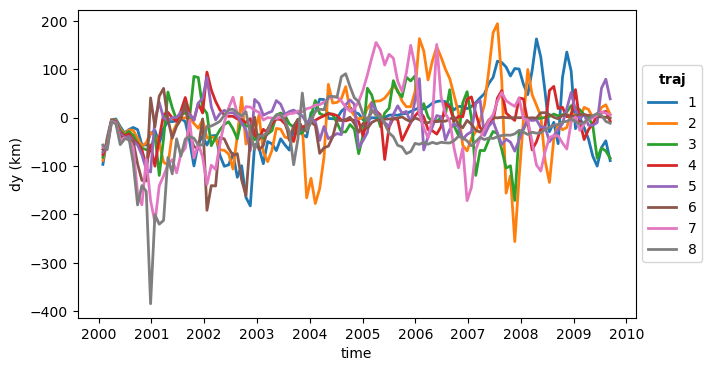

In [18]:
# Creating a time series plot of the meridional displacement travelled 
# by the first 10 particles in our ORCA1 output data.
traj.filter_between('id', 0, 9).compute_dy().plot_timeseries('dy')

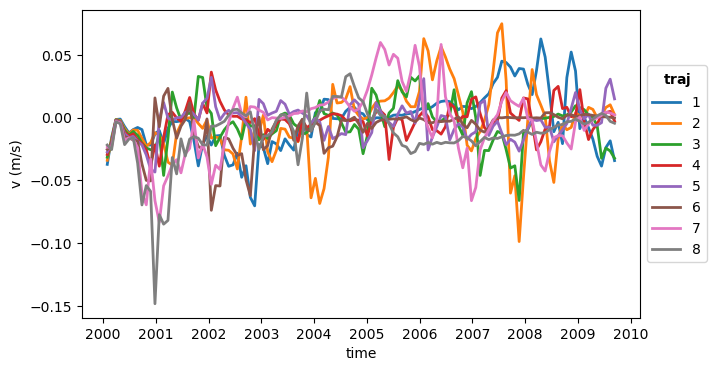

In [19]:
# Creating a time series plot of the meridional velocity travelled by 
# the first 10 particles in our ORCA1 output data.
traj.filter_between('id', 0, 9).compute_v().plot_timeseries('v')

### Computing Lagrangian probability distributions.

In [20]:
# Computing Lagrangian probability distribution for all trajectories
# released in seed_level 1 using 1x1 degree bins.
traj_prob = traj.filter_equal('seed_level', 1).compute_probability(bin_res=1, method='traj')

# Let's look at traj_prob.
print(traj_prob)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs', 'y', 'x']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory   (traj, obs) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    time         (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT NaT
    lat          (traj, obs) float64 67.39 66.53 66.16 66.12 ... nan nan nan nan
    lon          (traj, obs) float64 -63.27 -62.68 -63.37 -63.63 ... nan nan nan
    z            (traj, obs) float64 -0.2529 -0.4704 -2.156 ... nan nan nan
    vol          (traj, obs) float64 ...
    temp         (traj, obs) float64 -1.72 -1.72 -1.75 -1.77 ... nan nan nan nan
    sal          (traj, obs) float64 ...
    sigma0       (traj, obs) float64 ...
    id           (traj) int64 1 2 3 4 5 6 7 8 ... 794 795 796 797 798 799 800
    seed_level   (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    temp_K       (traj, obs) float64 271.4

In [21]:
# Computing Lagrangian probability distribution for all trajectories
# released in seed_levels 1 to 3 using 1x1 degree bins. 
traj_probs = traj.filter_between('seed_level', 1, 3).compute_probability(bin_res=1, method='pos', group_by='seed_level')

# Here the group_by function ensures that three seperate probability
# distributions are computed.
print(traj_probs)

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs', 'y', 'x', 'sample']

Trajectories: 800
Observations: 120
------------------------------------------ 
Data variables:
    trajectory   (traj, obs) float64 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    time         (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT NaT
    lat          (traj, obs) float64 67.39 66.53 66.16 66.12 ... nan nan nan nan
    lon          (traj, obs) float64 -63.27 -62.68 -63.37 -63.63 ... nan nan nan
    z            (traj, obs) float64 -0.2529 -0.4704 -2.156 ... nan nan nan
    vol          (traj, obs) float64 ...
    temp         (traj, obs) float64 -1.72 -1.72 -1.75 -1.77 ... nan nan nan nan
    sal          (traj, obs) float64 ...
    sigma0       (traj, obs) float64 ...
    id           (traj) int64 1 2 3 4 5 6 7 8 ... 794 795 796 797 798 799 800
    seed_level   (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    temp_K       (traj, obs) flo

### Conducting sensitivity analyses using Lagrangian probability distributions.

One of the central questions in Lagrangian studies is how should one choose the number and locations of particles to release into their model domain. 

A commonly used metric, originally developed for biological connectivity studies, is to compute the fraction of unexplained variance (FUV) between Lagrangian probability distributions. 

Such a sensitivity analysis begins by computing a reference Lagrangian probability distribution from the most comprehensive simulation (seeding the largest number of particles computationally possible). 
By randomly resampling trajectories from the reference simulation, a collection of resampled Lagrangian probability distributions are subsequently computed. Linear correlation coefficients are then calculated between the reference and resampled probability distributions, before the FUV is finally computed using the equation:

$FUV = 1 - r^{2}$
where $r$ is the linear correlation coefficient.

In [22]:
# How many particles should be released in the first seed level to
# ensure that the Lagrangian probability distribution of particle
# positions does not differ more then 5% from the reference?
traj.filter_equal('seed_level', 1).compute_fuv(bin_res=0.25, method='pos', resample=[10, 100, 200, 500, 700, 800], repeats=100, upper_bound=0.95, gf_sigma=None, group_by=None)

# Results suggest 700-800 particles should be released for the
# 95% upper bound of FUV < 0.05 (r > 0.97).

array([0.84232078, 0.51631824, 0.32663715, 0.09212563, 0.02181512,
       0.        ])

### Further plotting of seawater properties.

Another useful plot for examining the water mass properties of a given trajectory is the temperature-salinity (t-s) diagram. 

We can very easily produce a t-s diagram with the LT Toolbox using the **.plot_ts_diagram** method.

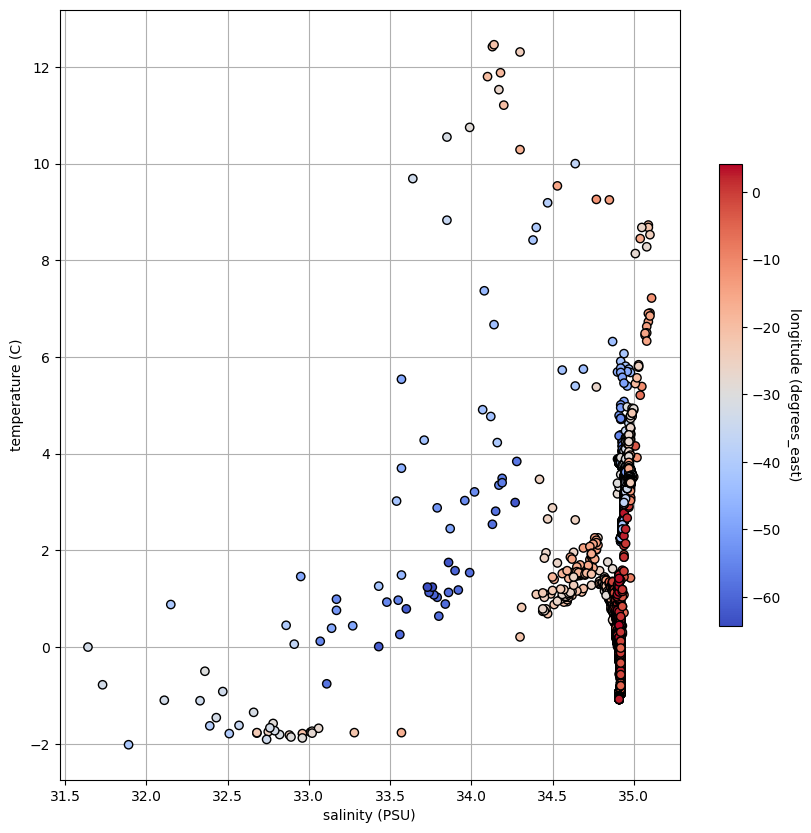

In [23]:
# Creating a t-s plot for the particles released between 2000-4000m
# in seeding level 1 and colouring by the particle longitude of 
# release.
traj.filter_equal('seed_level', 1).filter_between('z', -4000, -2000).plot_ts_diagram(col_variable='lon')

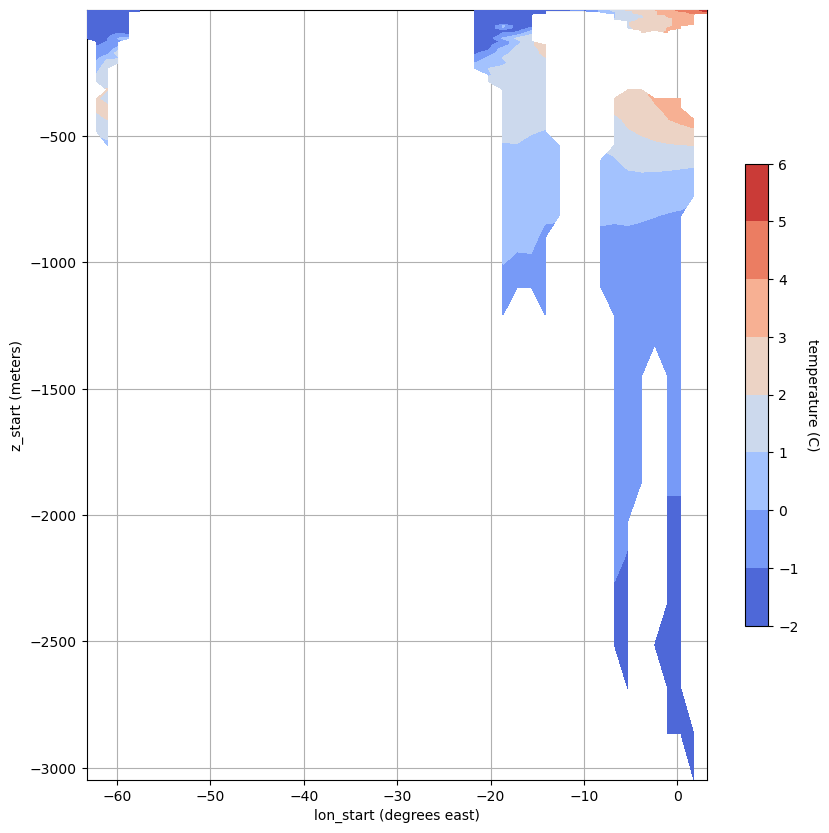

In [24]:
# Plotting temperature of the particles released at the
# first seeding level on 2000-03-01 (3rd time level).
traj.plot_variable('temp', 'xz', 1, '2000-03-01')

### Mapping trajectories and probability distributions with Cartopy.

The LT Toolbox utilises the highly adaptable Cartopy geospatial visualisation package to map trajectories and their properties on the Earth's surface. 

Below we show how to use **.map_trajectories**, **.map_probability()** and **.map_property()** methods when anaysing trajectory output data.

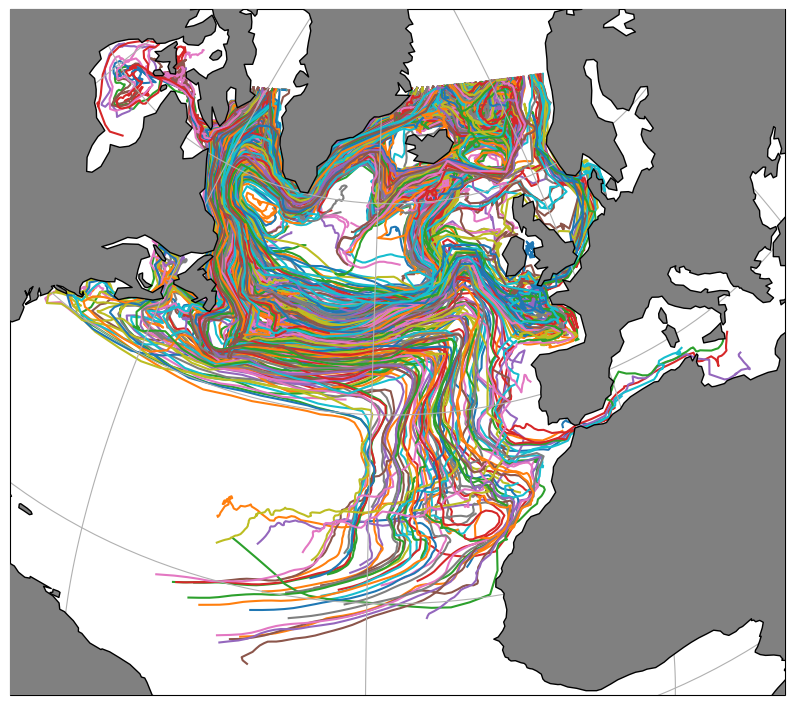

In [25]:
# Creating a map of trajectories released during the first seeding 
# levels (Jan - March).
traj.filter_equal('seed_level', 1).map_trajectories()

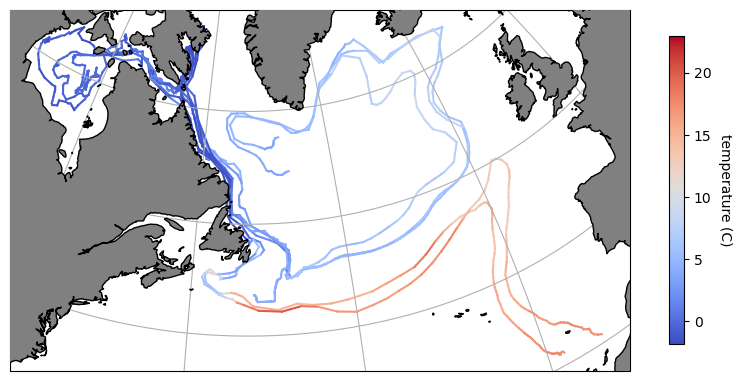

In [26]:
# Creating a map of the trajectories of the first 20 particles released,
# coloured by the in-situ temperature.
traj.filter_between('id', 0, 10).map_trajectories(col_variable='temp')

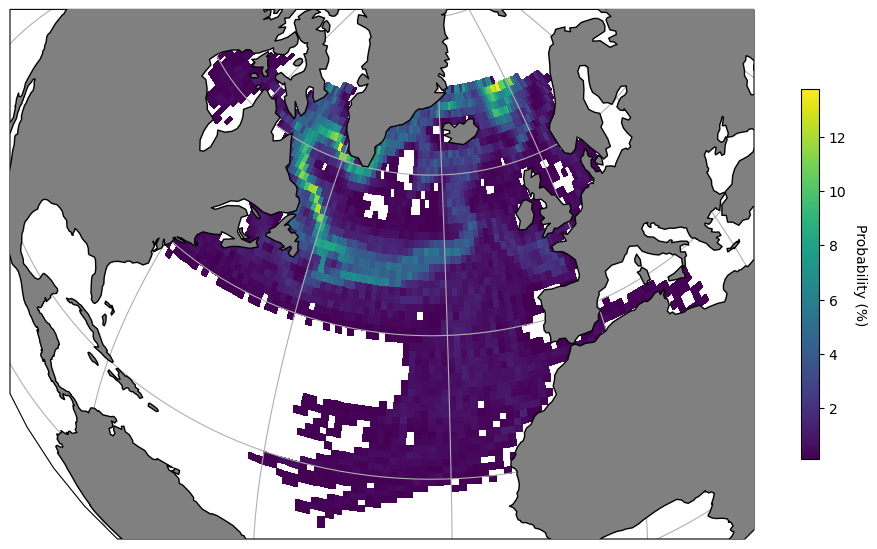

In [27]:
# Creating a map of the binned probability of particle pathways.
traj.map_probability(bin_res=1, prob_type='traj', cmap='viridis')

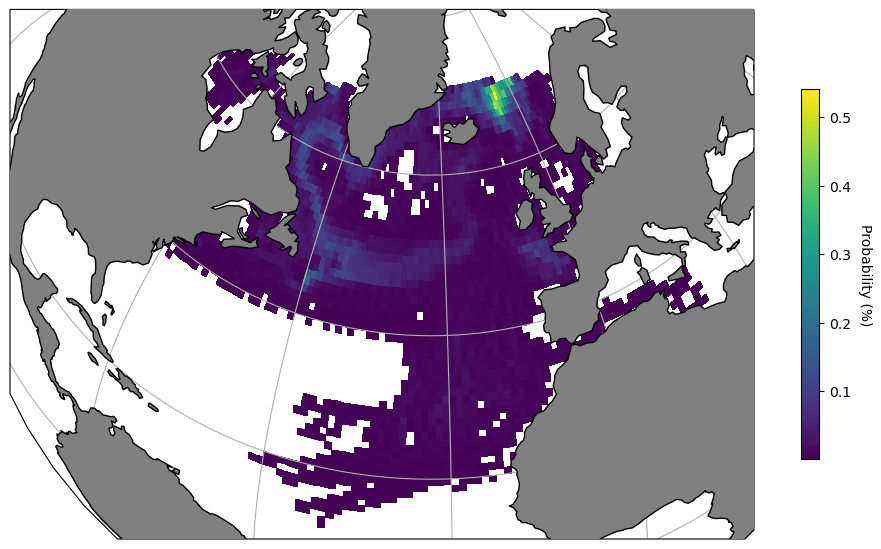

In [28]:
# Creating a map of the binned probability of particle positions.
traj.map_probability(bin_res=1, prob_type='pos', cmap='viridis')

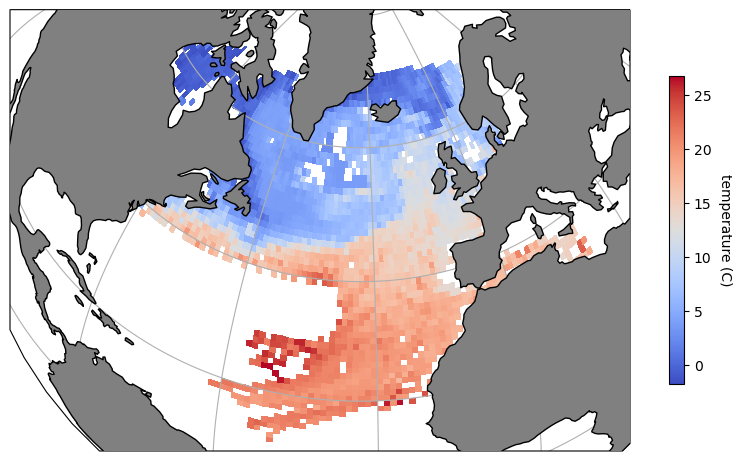

In [29]:
# Creating a map of the binned mean temperature of particles.
traj.map_property(bin_res=1, variable='temp', statistic='mean')

In [30]:
polygon = [[[-60, 30], [-60, 35], [-30, 35], [-30, 30], [-60, 30]]]
# Compute time to transit through polygon.
print(traj.filter_polygon(polygon=polygon, method='pos').compute_transit_time(polygon=polygon))

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 12
Observations: 120
------------------------------------------ 
Data variables:
    trajectory    (traj, obs) float64 12.0 12.0 12.0 12.0 ... 159.0 159.0 nan
    time          (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat           (traj, obs) float64 67.39 67.02 66.6 66.15 ... 24.54 24.31 nan
    lon           (traj, obs) float64 -63.27 -63.07 -62.77 ... -45.43 -45.74 nan
    z             (traj, obs) float64 -17.98 -30.83 -48.34 ... -109.0 -112.1 nan
    vol           (traj, obs) float64 ...
    temp          (traj, obs) float64 -1.72 -1.72 -1.73 ... 22.17 22.17 nan
    sal           (traj, obs) float64 ...
    sigma0        (traj, obs) float64 ...
    id            (traj) int64 12 13 28 76 77 83 84 90 129 131 137 159
    seed_level    (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K        (traj, obs) float64 271.4 271.4 271.4 ... 295.3 295.3 nan
    t_start 

In [31]:
# Compute residence time of trajectories inside polygon.
print(traj.filter_polygon(polygon=polygon, method='pos').compute_residence_time(polygon=polygon))

<TrajArray object>

------------------------------------------
Dimensions:  ['traj', 'obs']

Trajectories: 12
Observations: 120
------------------------------------------ 
Data variables:
    trajectory      (traj, obs) float64 12.0 12.0 12.0 12.0 ... 159.0 159.0 nan
    time            (traj, obs) datetime64[ns] 2000-01-01 2000-01-31 ... NaT
    lat             (traj, obs) float64 67.39 67.02 66.6 ... 24.54 24.31 nan
    lon             (traj, obs) float64 -63.27 -63.07 -62.77 ... -45.74 nan
    z               (traj, obs) float64 -17.98 -30.83 -48.34 ... -112.1 nan
    vol             (traj, obs) float64 ...
    temp            (traj, obs) float64 -1.72 -1.72 -1.73 ... 22.17 22.17 nan
    sal             (traj, obs) float64 ...
    sigma0          (traj, obs) float64 ...
    id              (traj) int64 12 13 28 76 77 83 84 90 129 131 137 159
    seed_level      (traj) int64 1 1 1 1 1 1 1 1 1 1 1 1
    temp_K          (traj, obs) float64 271.4 271.4 271.4 ... 295.3 295.3 nan
    t_st